In [19]:
# Import required libraries
import numpy as np
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier

In [2]:
# Step 1: Load MNIST dataset
mnist = fetch_openml('mnist_784', version=1)
X, y = mnist.data, mnist.target

# Convert labels to integers
y = y.astype(int)

# Convert dataframes to arrays
X = X.to_numpy()
y = y.to_numpy()

In [3]:
X

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int64)

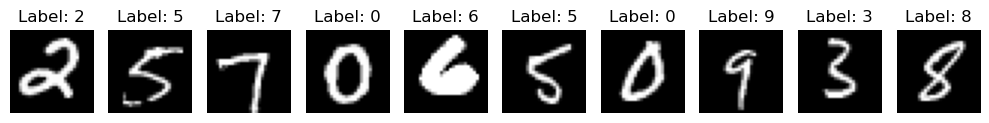

In [4]:
# Function to display random images
def plot_mnist_samples(X, y, num_samples=10):
    """
    Plots a grid of random sample images from the MNIST dataset.
    X: Feature matrix (flattened images).
    y: Labels corresponding to the images.
    num_samples: Number of images to display.
    """
    indices = np.random.choice(len(X), num_samples, replace=False)
    plt.figure(figsize=(10, 2))
    for i, idx in enumerate(indices):
        plt.subplot(1, num_samples, i + 1)
        plt.imshow(X[idx].reshape(28, 28), cmap='gray')
        plt.title(f"Label: {y[idx]}")
        plt.axis('off')
    plt.tight_layout()
    plt.show()

# Display 10 random images
plot_mnist_samples(X, y, num_samples=10)

In [5]:
subsample_size=20000

In [6]:
print('Starting Shape:',X.shape)
# Step 2: Preprocess the data
# Normalize pixel values (0-255) to (0-1)
X = X / 255.0

# Reduce dimensionality using PCA (retain 95% variance)
pca = PCA(n_components=0.95, random_state=42)
X_pca = pca.fit_transform(X)

# Subsample the data (10,000 cases for training)
subsample_indices = np.random.choice(len(X_pca), subsample_size, replace=False)
X_subsample = X_pca[subsample_indices]
y_subsample = y[subsample_indices]

print('Shape after transforming:',X_subsample.shape)

# Create an out-of-sample test set using the remaining indices
out_of_sample_indices = np.setdiff1d(np.arange(len(X_pca)), subsample_indices)
X_out_of_sample = X_pca[out_of_sample_indices]
y_out_of_sample = y[out_of_sample_indices]

# Split the subsample into training and validation sets
X_train, X_test, y_train, y_test = train_test_split(
    X_subsample, y_subsample, test_size=0.2, stratify=y_subsample, random_state=42
)

# Optional: Standardize the data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
X_out_of_sample = scaler.transform(X_out_of_sample)

Starting Shape: (70000, 784)
Shape after transforming: (20000, 154)


In [7]:
# Step 3: Hyperparameter tuning with GridSearchCV
param_grid = {
    'C': [0.1, 1, 10],
    'gamma': [0.01, 0.03, 0.1],
    'kernel': ['rbf']
}

grid_search = GridSearchCV(SVC(random_state=42), param_grid, cv=3, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train, y_train)

print("Best Parameters:", grid_search.best_params_)

# Train the best model
best_svm_model = grid_search.best_estimator_
best_svm_model.fit(X_train, y_train)

Best Parameters: {'C': 10, 'gamma': 0.01, 'kernel': 'rbf'}


SVC(C=10, gamma=0.01, random_state=42)

In [11]:
# Baseline model with Logistic Regression
logistic_model = LogisticRegression(max_iter=1000, random_state=42)
logistic_model.fit(X_train, y_train)

LogisticRegression(max_iter=1000, random_state=42)

In [15]:
# Logistic Regression GridSearch
param_grid_logreg = {
    'C': [0.01, 0.1, 1, 10, 100],
    'penalty': ['l2'],
    'solver': ['lbfgs']
}

grid_search_logreg = GridSearchCV(LogisticRegression(max_iter=1000, random_state=42), param_grid_logreg, cv=3, scoring='accuracy', n_jobs=-1)
grid_search_logreg.fit(X_train, y_train)

print("Logistic Regression Best Parameters:", grid_search_logreg.best_params_)

# Train the best Logistic Regression model
best_logreg_model = grid_search_logreg.best_estimator_
best_logreg_model.fit(X_train, y_train)

Logistic Regression Best Parameters: {'C': 0.1, 'penalty': 'l2', 'solver': 'lbfgs'}


LogisticRegression(C=0.1, max_iter=1000, random_state=42)

In [20]:
# Random Forest GridSearch
param_grid_rf = {
    'n_estimators': [50, 100, 200],
    'max_depth': [2,6, 10, 15],
    'min_samples_split': [2, 5, 10]
}

grid_search_rf = GridSearchCV(RandomForestClassifier(random_state=42), param_grid_rf, cv=3, scoring='accuracy', n_jobs=-1)
grid_search_rf.fit(X_train, y_train)

print("Random Forest Best Parameters:", grid_search_rf.best_params_)

# Train the best Random Forest model
best_rf_model = grid_search_rf.best_estimator_
best_rf_model.fit(X_train, y_train)

Random Forest Best Parameters: {'max_depth': 15, 'min_samples_split': 2, 'n_estimators': 200}


RandomForestClassifier(max_depth=15, n_estimators=200, random_state=42)

In [21]:
# LightGBM GridSearch
param_grid_lgbm = {
    'num_leaves': [31, 50, 100],
    'learning_rate': [0.01, 0.1, 0.3],
    'n_estimators': [50, 100, 200]
}

grid_search_lgbm = GridSearchCV(LGBMClassifier(random_state=42), param_grid_lgbm, cv=3, scoring='accuracy', n_jobs=-1)
grid_search_lgbm.fit(X_train, y_train)

print("LightGBM Best Parameters:", grid_search_lgbm.best_params_)

# Train the best LightGBM model
best_lgbm_model = grid_search_lgbm.best_estimator_
best_lgbm_model.fit(X_train, y_train)


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007958 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 39270
[LightGBM] [Info] Number of data points in the train set: 16000, number of used features: 154
[LightGBM] [Info] Start training from score -2.339508
[LightGBM] [Info] Start training from score -2.199916
[LightGBM] [Info] Start training from score -2.287081
[LightGBM] [Info] Start training from score -2.282782
[LightGBM] [Info] Start training from score -2.346015
[LightGBM] [Info] Start training from score -2.396209
[LightGBM] [Info] Start training from score -2.312635
[LightGBM] [Info] Start training from score -2.265771
[LightGBM] [Info] Start training from score -2.284009
[LightGBM] [Info] Start training from score -2.324703
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning

LGBMClassifier(n_estimators=200, random_state=42)

In [12]:
# Step 4: Evaluate the models
def evaluate_model(model, X_train, y_train, X_test, y_test, X_out, y_out, model_name="Model"):
    """
    Evaluates the given model and prints performance metrics.
    Plots the confusion matrix for the out-of-sample data.
    """
    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)
    y_pred_out = model.predict(X_out)

    train_accuracy = accuracy_score(y_train, y_pred_train)
    test_accuracy = accuracy_score(y_test, y_pred_test)
    out_accuracy = accuracy_score(y_out, y_pred_out)

    print(f"\n{model_name} Performance:")
    print(f"Training Accuracy: {train_accuracy * 100:.2f}%")
    print(f"Validation Accuracy: {test_accuracy * 100:.2f}%")
    print(f"Out-of-Sample Accuracy: {out_accuracy * 100:.2f}%")

    print("Classification Report (Out-of-Sample Test Data):")
    print(classification_report(y_out, y_pred_out))

    # ConfusionMatrixDisplay.from_estimator(model, X_out, y_out, cmap='Blues')
    # plt.title(f"Confusion Matrix ({model_name})")
    plt.show()


SVM Performance:
Training Accuracy: 100.00%
Validation Accuracy: 96.12%
Out-of-Sample Accuracy: 95.91%
Classification Report (Out-of-Sample Test Data):
              precision    recall  f1-score   support

           0       0.98      0.97      0.98      4976
           1       0.99      0.98      0.98      5661
           2       0.91      0.97      0.94      4959
           3       0.96      0.94      0.95      5101
           4       0.96      0.96      0.96      4909
           5       0.96      0.94      0.95      4492
           6       0.98      0.96      0.97      4896
           7       0.98      0.95      0.97      5218
           8       0.91      0.97      0.94      4787
           9       0.97      0.93      0.95      5001

    accuracy                           0.96     50000
   macro avg       0.96      0.96      0.96     50000
weighted avg       0.96      0.96      0.96     50000



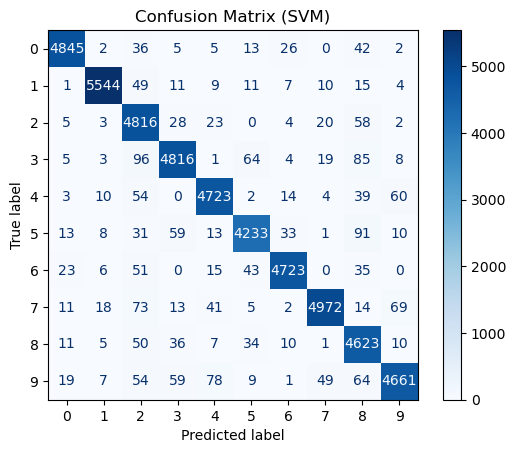

In [13]:
evaluate_model(best_svm_model, X_train, y_train, X_test, y_test, X_out_of_sample, y_out_of_sample, model_name="SVM")


Logistic Regression Performance:
Training Accuracy: 93.58%
Validation Accuracy: 91.05%
Out-of-Sample Accuracy: 91.26%
Classification Report (Out-of-Sample Test Data):
              precision    recall  f1-score   support

           0       0.95      0.95      0.95      4976
           1       0.95      0.97      0.96      5661
           2       0.91      0.90      0.90      4959
           3       0.90      0.88      0.89      5101
           4       0.92      0.92      0.92      4909
           5       0.87      0.86      0.86      4492
           6       0.93      0.94      0.94      4896
           7       0.93      0.93      0.93      5218
           8       0.87      0.87      0.87      4787
           9       0.89      0.89      0.89      5001

    accuracy                           0.91     50000
   macro avg       0.91      0.91      0.91     50000
weighted avg       0.91      0.91      0.91     50000



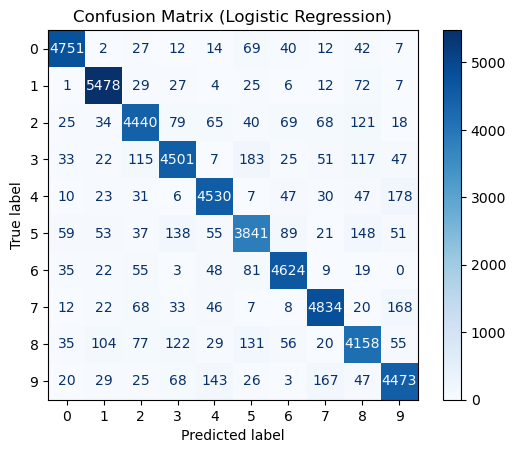

In [14]:
evaluate_model(logistic_model, X_train, y_train, X_test, y_test, X_out_of_sample, y_out_of_sample, model_name="Logistic Regression")


Tuned Logistic Regression Performance:
Training Accuracy: 93.14%
Validation Accuracy: 91.07%
Out-of-Sample Accuracy: 91.20%
Classification Report (Out-of-Sample Test Data):
              precision    recall  f1-score   support

           0       0.96      0.96      0.96      4976
           1       0.94      0.97      0.95      5661
           2       0.91      0.89      0.90      4959
           3       0.91      0.88      0.89      5101
           4       0.91      0.92      0.92      4909
           5       0.87      0.86      0.86      4492
           6       0.93      0.94      0.94      4896
           7       0.93      0.92      0.93      5218
           8       0.87      0.87      0.87      4787
           9       0.89      0.89      0.89      5001

    accuracy                           0.91     50000
   macro avg       0.91      0.91      0.91     50000
weighted avg       0.91      0.91      0.91     50000



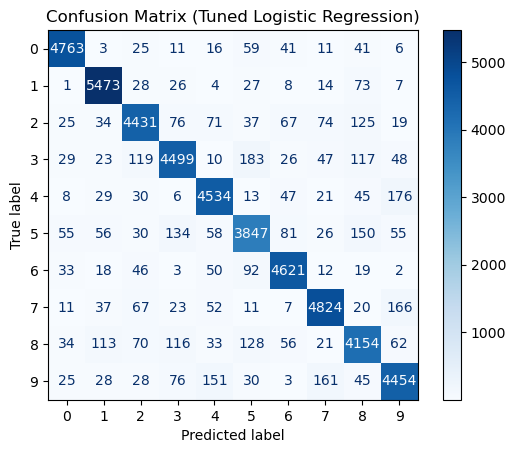

In [22]:
evaluate_model(best_logreg_model, X_train, y_train, X_test, y_test, X_out_of_sample, y_out_of_sample, model_name="Tuned Logistic Regression")


Random Forest Performance:
Training Accuracy: 100.00%
Validation Accuracy: 93.17%
Out-of-Sample Accuracy: 92.99%
Classification Report (Out-of-Sample Test Data):
              precision    recall  f1-score   support

           0       0.96      0.96      0.96      4976
           1       0.97      0.97      0.97      5661
           2       0.93      0.92      0.92      4959
           3       0.90      0.91      0.91      5101
           4       0.93      0.93      0.93      4909
           5       0.92      0.91      0.91      4492
           6       0.95      0.96      0.96      4896
           7       0.94      0.94      0.94      5218
           8       0.89      0.88      0.89      4787
           9       0.91      0.90      0.90      5001

    accuracy                           0.93     50000
   macro avg       0.93      0.93      0.93     50000
weighted avg       0.93      0.93      0.93     50000



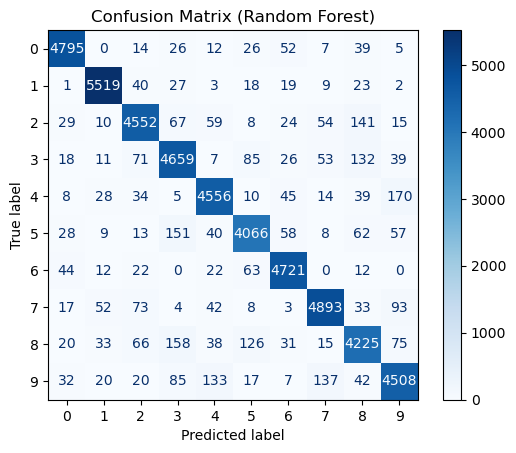

In [23]:
evaluate_model(best_rf_model, X_train, y_train, X_test, y_test, X_out_of_sample, y_out_of_sample, model_name="Random Forest")


Light GBM Performance:
Training Accuracy: 100.00%
Validation Accuracy: 95.88%
Out-of-Sample Accuracy: 95.45%
Classification Report (Out-of-Sample Test Data):
              precision    recall  f1-score   support

           0       0.97      0.98      0.98      4976
           1       0.98      0.98      0.98      5661
           2       0.96      0.96      0.96      4959
           3       0.95      0.94      0.94      5101
           4       0.95      0.95      0.95      4909
           5       0.94      0.94      0.94      4492
           6       0.96      0.97      0.96      4896
           7       0.96      0.96      0.96      5218
           8       0.94      0.94      0.94      4787
           9       0.94      0.93      0.93      5001

    accuracy                           0.95     50000
   macro avg       0.95      0.95      0.95     50000
weighted avg       0.95      0.95      0.95     50000



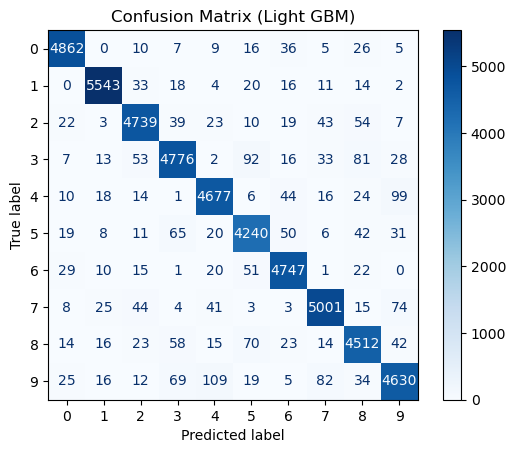

In [24]:
evaluate_model(best_lgbm_model, X_train, y_train, X_test, y_test, X_out_of_sample, y_out_of_sample, model_name="Light GBM")